In [86]:
!pip install --upgrade setuptools
!pip install lxml
!pip install geocoder
!pip install folium
!pip install area
!pip install geojson
!pip install pyproj
!pip install shapely


import io
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import geocoder 
import folium # map rendering library
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from area import area
import geojson
from shapely.geometry import Polygon
from shapely.ops import transform
import pyproj

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

Requirement already up-to-date: setuptools in /opt/conda/envs/Python36/lib/python3.6/site-packages (42.0.2)


In [87]:
neighborhoods2 = pd.read_csv(f"https://raw.githubusercontent.com/DirkFritz/Coursera_Capstone/master/Neighbourhoods.csv")

neighborhoods2 = neighborhoods2[["AREA_SHORT_CODE", "AREA_NAME", "LONGITUDE", "LATITUDE"]]
neighborhoods2=neighborhoods2.set_index("AREA_SHORT_CODE")


In [88]:


crimeData = pd.read_csv(f"https://raw.githubusercontent.com/DirkFritz/Coursera_Capstone/master/Neighbourhood_Crime_Rates_Boundary_File.csv")
#crimeData


In [89]:
neighborhoods2["Crime Rate"]= 0
for idx, row in crimeData.iterrows():
    hoodId = crimeData.loc[idx,"Hood_ID"]
    crimeRate = crimeData.loc[idx,"Assault_2018"] + crimeData.loc[idx,"Auto_Theft_2018"] + crimeData.loc[idx,"BreakandEnter_2018"] + crimeData.loc[idx,"Robbery_2018"] + crimeData.loc[idx,"Theft_Over_2018"] + crimeData.loc[idx,"Homicide_2018"]
    neighborhoods2.loc[hoodId,"Crime Rate"]=crimeRate
   # neighborhoods2.loc[hoodId,"AREA_NAME"]=crimeData.loc[idx,"Neighbourhood"]
   # print(str(idx) + " "+str(hoodId) + " " + "N "+str(neighborhoods2.loc[hoodId,"Crime Rate"]) + str(neighborhoods2.loc[hoodId,"AREA_NAME"]) )
#neighborhoods2.sort_values("AREA_NAME", ascending=True)
neighborhoods2

,AREA_NAME,LONGITUDE,LATITUDE,Crime Rate
AREA_SHORT_CODE,,,,
94,Wychwood (94),-79.425515,43.676919,NaN
100,Yonge-Eglinton (100),-79.403590,43.704689,66.0
97,Yonge-St.Clair (97),-79.397871,43.687859,175.0
27,York University Heights (27),-79.488883,43.765736,231.0
31,Yorkdale-Glen Park (31),-79.457108,43.714672,261.0
114,Lambton Baby Point (114),-79.496045,43.657420,187.0
38,Lansing-Westgate (38),-79.424748,43.754271,318.0
105,Lawrence Park North (105),-79.403978,43.730060,404.0
103,Lawrence Park South (103),-79.406039,43.717212,233.0


In [90]:
import urllib.request
from functools import partial 
torontoNeighBoundries = "https://raw.githubusercontent.com/DirkFritz/Coursera_Capstone/master/Neighbourhoods.geojson"

content=urllib.request.urlopen(torontoNeighBoundries)
    
gj = geojson.load(content)


neighborhoods2["Area m^2"]=0
for i in range(0,len(gj['features'])):           
    features = gj['features'][i]
    poly =features["geometry"]
    poly["type"]="Polygon"
    polygon = Polygon(poly['coordinates'][0])
    geom_area = transform(
    partial(
        pyproj.transform,
        pyproj.Proj(init='EPSG:4326'),
        pyproj.Proj(
            proj='aea',
            lat_1=polygon.bounds[3],
            lat_2=polygon.bounds[1])),
    polygon)
    hoodId= features["properties"]["AREA_SHORT_CODE"]
    neighborhoods2.loc[hoodId,"Area m^2"]=round(geom_area.area,0)
    

neighborhoods2=neighborhoods2.sort_values("AREA_NAME").reset_index()
neighborhoods2

/opt/conda/envs/Python36/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/envs/Python36/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/envs/Python36/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/envs/Python36/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/envs/Python36

,AREA_SHORT_CODE,AREA_NAME,LONGITUDE,LATITUDE,Crime Rate,Area m^2
0,129,Agincourt North (129),-79.266712,43.805441,513.0,7264393.0
1,128,Agincourt South-Malvern West (128),-79.265612,43.788658,154.0,7875876.0
2,20,Alderwood (20),-79.541611,43.604937,223.0,4980675.0
3,95,Annex (95),-79.404001,43.671585,154.0,2791395.0
4,42,Banbury-Don Mills (42),-79.349718,43.737657,81.0,10045354.0
5,34,Bathurst Manor (34),-79.456055,43.764813,674.0,4762402.0
6,76,Bay Street Corridor (76),-79.385721,43.657511,59.0,1809967.0
7,52,Bayview Village (52),-79.377117,43.776361,139.0,5161147.0
8,49,Bayview Woods-Steeles (49),-79.382118,43.796802,96.0,4090512.0
9,39,Bedford Park-Nortown (39),-79.420227,43.731486,135.0,5520505.0


In [91]:

df_data_0 = pd.read_csv("https://raw.githubusercontent.com/DirkFritz/Coursera_Capstone/master/neighbourhood-profiles-2016-csv.csv")
population = df_data_0.iloc[2,:]
population=population.drop(["_id", "Category","Topic", "Data Source", "Characteristic", "City of Toronto"],axis=0)
print(population)
neighborhoods2["Population"]=0
for idx, row in neighborhoods2.iterrows():
    neighborhoods2.loc[idx, "Population"]=int(population[idx].replace(",",""))

neighborhoods2
    
 



Agincourt North                      29,113
Agincourt South-Malvern West         23,757
Alderwood                            12,054
Annex                                30,526
Banbury-Don Mills                    27,695
Bathurst Manor                       15,873
Bay Street Corridor                  25,797
Bayview Village                      21,396
Bayview Woods-Steeles                13,154
Bedford Park-Nortown                 23,236
Beechborough-Greenbrook               6,577
Bendale                              29,960
Birchcliffe-Cliffside                22,291
Black Creek                          21,737
Blake-Jones                           7,727
Briar Hill-Belgravia                 14,257
Bridle Path-Sunnybrook-York Mills     9,266
Broadview North                      11,499
Brookhaven-Amesbury                  17,757
Cabbagetown-South St. James Town     11,669
Caledonia-Fairbank                    9,955
Casa Loma                            10,968
Centennial Scarborough          

,AREA_SHORT_CODE,AREA_NAME,LONGITUDE,LATITUDE,Crime Rate,Area m^2,Population
0,129,Agincourt North (129),-79.266712,43.805441,513.0,7264393.0,29113
1,128,Agincourt South-Malvern West (128),-79.265612,43.788658,154.0,7875876.0,23757
2,20,Alderwood (20),-79.541611,43.604937,223.0,4980675.0,12054
3,95,Annex (95),-79.404001,43.671585,154.0,2791395.0,30526
4,42,Banbury-Don Mills (42),-79.349718,43.737657,81.0,10045354.0,27695
5,34,Bathurst Manor (34),-79.456055,43.764813,674.0,4762402.0,15873
6,76,Bay Street Corridor (76),-79.385721,43.657511,59.0,1809967.0,25797
7,52,Bayview Village (52),-79.377117,43.776361,139.0,5161147.0,21396
8,49,Bayview Woods-Steeles (49),-79.382118,43.796802,96.0,4090512.0,13154
9,39,Bedford Park-Nortown (39),-79.420227,43.731486,135.0,5520505.0,23236


/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,AREA_SHORT_CODE,AREA_NAME,LONGITUDE,LATITUDE,Crime Rate,Area m^2,Population,Person Per m^2
0,129,Agincourt North (129),-79.266712,43.805441,1762.099406,7264393.0,29113,0.004008
1,128,Agincourt South-Malvern West (128),-79.265612,43.788658,648.229995,7875876.0,23757,0.003016
2,20,Alderwood (20),-79.541611,43.604937,1850.008296,4980675.0,12054,0.002420
3,95,Annex (95),-79.404001,43.671585,504.487977,2791395.0,30526,0.010936
4,42,Banbury-Don Mills (42),-79.349718,43.737657,292.471565,10045354.0,27695,0.002757
5,34,Bathurst Manor (34),-79.456055,43.764813,4246.204246,4762402.0,15873,0.003333
6,76,Bay Street Corridor (76),-79.385721,43.657511,228.708765,1809967.0,25797,0.014253
7,52,Bayview Village (52),-79.377117,43.776361,649.654141,5161147.0,21396,0.004146
8,49,Bayview Woods-Steeles (49),-79.382118,43.796802,729.816026,4090512.0,13154,0.003216
9,39,Bedford Park-Nortown (39),-79.420227,43.731486,580.995008,5520505.0,23236,0.004209


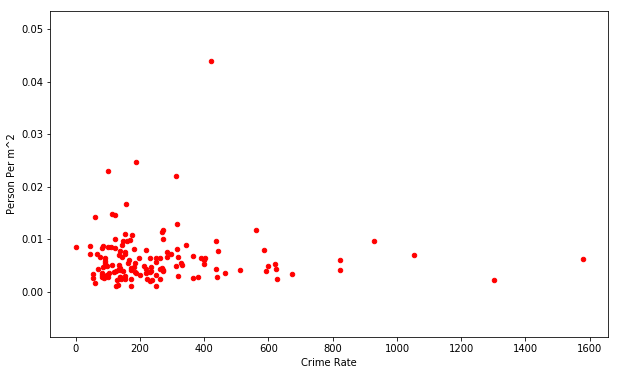

In [92]:
neighborhoods2=neighborhoods2.fillna(0)
crimeToPop =neighborhoods2[["AREA_NAME","Crime Rate"]]
crimeToPop.loc[:,"Person Per m^2"] = neighborhoods2["Population"]/neighborhoods2["Area m^2"]
neighborhoods2.loc[:,"Person Per m^2"]= neighborhoods2["Population"]/neighborhoods2["Area m^2"]
neighborhoods2.loc[:,"Crime Rate"]= (neighborhoods2["Crime Rate"]/neighborhoods2["Population"])*100000

crimeToPop.plot(kind='scatter', x='Crime Rate', y='Person Per m^2', figsize=(10, 6), color='red')
crimeToPop.sort_values("Person Per m^2", ascending=False)
neighborhoods2

In [93]:
CLIENT_ID = "WKQBB1DZI22C3IPI4ADEQIKOA1PYAITSAN3NIY3VLMFTNSMG" # your Foursquare ID
CLIENT_SECRET = 'LTVCWEBBOCNZYZX4K35HI4Z25HE2XQTT4GJ2DWOK21HIPIOC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WKQBB1DZI22C3IPI4ADEQIKOA1PYAITSAN3NIY3VLMFTNSMG
CLIENT_SECRET:LTVCWEBBOCNZYZX4K35HI4Z25HE2XQTT4GJ2DWOK21HIPIOC


In [94]:
def getNearbyVenues(hoodId, names, latitudes, longitudes,categoryId, radius=500):
    
    venues_list=[]
    for hoodId, name, lat, lng in zip(hoodId, names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT, categoryId)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            hoodId,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['hoodId','Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue Id']
    
    return(nearby_venues)

In [95]:


LIMIT = 500 # limit of number of venues returned by Foursquare API
radius = 750 # define radius
categoryId = "4d4b7105d754a06374d81259"

area_venues = getNearbyVenues(hoodId=neighborhoods2['AREA_SHORT_CODE'], names=neighborhoods2['AREA_NAME'],
                                   latitudes=neighborhoods2['LATITUDE'],
                                   longitudes=neighborhoods2['LONGITUDE'], categoryId=categoryId
                                  )
area_venues

,hoodId,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Id
0,129,Agincourt North (129),43.805441,-79.266712,Congee Town 太皇名粥,43.809035,-79.267634,Chinese Restaurant,4bf58dd8d48988d145941735
1,129,Agincourt North (129),43.805441,-79.266712,Subway,43.809007,-79.267627,Sandwich Place,4bf58dd8d48988d1c5941735
2,129,Agincourt North (129),43.805441,-79.266712,KFC,43.808357,-79.267822,Fast Food Restaurant,4bf58dd8d48988d16e941735
3,129,Agincourt North (129),43.805441,-79.266712,Pizza Pizza,43.808318,-79.268537,Pizza Place,4bf58dd8d48988d1ca941735
4,129,Agincourt North (129),43.805441,-79.266712,Popeyes Louisiana Kitchen,43.808652,-79.267929,Fried Chicken Joint,4d4ae6fc7a7b7dea34424761
5,129,Agincourt North (129),43.805441,-79.266712,Wild Wing,43.808799,-79.267808,Wings Joint,4bf58dd8d48988d14c941735
6,129,Agincourt North (129),43.805441,-79.266712,Casa Deluz 豪門宴,43.808955,-79.268113,Dim Sum Restaurant,4bf58dd8d48988d1f5931735
7,129,Agincourt North (129),43.805441,-79.266712,Kin Kin Bubble Tea Co,43.807852,-79.270296,Chinese Restaurant,4bf58dd8d48988d145941735
8,129,Agincourt North (129),43.805441,-79.266712,Everbest Bakery,43.808899,-79.269629,Bakery,4bf58dd8d48988d16a941735
9,129,Agincourt North (129),43.805441,-79.266712,Xe Lua Vietnamese Cuisine 火車頭,43.809224,-79.269547,Vietnamese Restaurant,4bf58dd8d48988d14a941735


In [96]:
# one hot encodin
area_onehot = pd.get_dummies(area_venues[['Venue Id']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
area_onehot["AREA_SHORT_CODE"]= ""
area_onehot["AREA_SHORT_CODE"] = area_venues["hoodId"] 

fixed_columns = [area_onehot.columns[-1]] + list(area_onehot.columns[:-1])
area_onehot = area_onehot[fixed_columns]

area_grouped = area_onehot.groupby('AREA_SHORT_CODE').mean().reset_index()
#area_grouped
area_grouped_sum = area_onehot.groupby('AREA_SHORT_CODE').sum().reset_index()
area_grouped = area_grouped.set_index('AREA_SHORT_CODE')
area_grouped_sum = area_grouped_sum.set_index('AREA_SHORT_CODE')
area_grouped_sum








,4bf58dd8d48988d107941735,4bf58dd8d48988d108941735,4bf58dd8d48988d109941735,4bf58dd8d48988d10a941735,4bf58dd8d48988d10b941735,4bf58dd8d48988d10c941735,4bf58dd8d48988d10d941735,4bf58dd8d48988d10e941735,4bf58dd8d48988d10f941735,4bf58dd8d48988d110941735,...,54135bf5e4b08f3d2429dfdd,54135bf5e4b08f3d2429dfdf,55a59bace4b013909087cb24,56aa371be4b08b9a8d5734c7,56aa371be4b08b9a8d57350b,56aa371be4b08b9a8d573529,56aa371be4b08b9a8d573568,5bae9231bedf3950379f89d4,5bae9231bedf3950379f89da,5bae9231bedf3950379f89e1
AREA_SHORT_CODE,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
neighborhoods2["Probability Venue"]=0
neighborhoods2["Sum Venue"]=0
neighborhoods2 = neighborhoods2.set_index('AREA_SHORT_CODE')

for hoodId, row in area_grouped.iterrows():
    #print(neighborhoods2.loc[hoodId, "AREA_NAME"] + str(area_grouped.loc[hoodId,"4bf58dd8d48988d1ca941735"]))
    neighborhoods2.loc[hoodId, "Probability Venue"]=area_grouped.loc[hoodId,"4bf58dd8d48988d1ca941735"]
    neighborhoods2.loc[hoodId, "Sum Venue"]=area_grouped_sum.loc[hoodId,"4bf58dd8d48988d1ca941735"]
neighborhoods2.head(100)
#area_grouped


,AREA_NAME,LONGITUDE,LATITUDE,Crime Rate,Area m^2,Population,Person Per m^2,Probability Venue,Sum Venue
AREA_SHORT_CODE,,,,,,,,,
129,Agincourt North (129),-79.266712,43.805441,1762.099406,7264393.0,29113,0.004008,0.090909,1
128,Agincourt South-Malvern West (128),-79.265612,43.788658,648.229995,7875876.0,23757,0.003016,0.041667,1
20,Alderwood (20),-79.541611,43.604937,1850.008296,4980675.0,12054,0.002420,0.400000,2
95,Annex (95),-79.404001,43.671585,504.487977,2791395.0,30526,0.010936,0.058824,1
42,Banbury-Don Mills (42),-79.349718,43.737657,292.471565,10045354.0,27695,0.002757,0.400000,2
34,Bathurst Manor (34),-79.456055,43.764813,4246.204246,4762402.0,15873,0.003333,0.500000,1
76,Bay Street Corridor (76),-79.385721,43.657511,228.708765,1809967.0,25797,0.014253,0.076923,5
52,Bayview Village (52),-79.377117,43.776361,649.654141,5161147.0,21396,0.004146,0.000000,0
49,Bayview Woods-Steeles (49),-79.382118,43.796802,729.816026,4090512.0,13154,0.003216,0.000000,0


In [98]:
from sklearn.preprocessing import StandardScaler

X = neighborhoods2.values[:,[3, 6 ,8]]

num_clusters = 5

X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 1.12579844e-01, -4.54488796e-01,  5.33153276e-02],
       [-6.32027926e-01, -6.50210893e-01,  5.33153276e-02],
       [ 1.71345838e-01, -7.67950258e-01,  7.99729915e-01],
       [-7.28117667e-01,  9.13530980e-01,  5.33153276e-02],
       [-8.69847987e-01, -7.01437768e-01,  7.99729915e-01],
       [ 1.77317286e+00, -5.87704139e-01,  5.33153276e-02],
       [-9.12472622e-01,  1.56850155e+00,  3.03897368e+00],
       [-6.31075902e-01, -4.27247347e-01, -6.93099259e-01],
       [-5.77488685e-01, -6.10855734e-01, -6.93099259e-01],
       [-6.76973674e-01, -4.14719540e-01,  1.54614450e+00],
       [ 8.45473897e-01, -5.37857724e-01, -6.93099259e-01],
       [-4.56225771e-01, -4.52699003e-01, -6.93099259e-01],
       [-7.05492120e-01, -5.13578964e-01,  7.99729915e-01],
       [ 3.79060637e+00, -3.67526381e-03,  5.33153276e-02],
       [-3.55953334e-01,  3.74670423e-01,  5.33153276e-02],
       [-4.13613225e-01,  2.91597037e-01,  5.33153276e-02],
       [-1.56345554e-01, -1.03890083e+00

In [99]:

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_
labels
neighborhoods2["Labels"] = labels
neighborhoods2



,AREA_NAME,LONGITUDE,LATITUDE,Crime Rate,Area m^2,Population,Person Per m^2,Probability Venue,Sum Venue,Labels
AREA_SHORT_CODE,,,,,,,,,,
129,Agincourt North (129),-79.266712,43.805441,1762.099406,7264393.0,29113,0.004008,0.090909,1,1
128,Agincourt South-Malvern West (128),-79.265612,43.788658,648.229995,7875876.0,23757,0.003016,0.041667,1,1
20,Alderwood (20),-79.541611,43.604937,1850.008296,4980675.0,12054,0.002420,0.400000,2,0
95,Annex (95),-79.404001,43.671585,504.487977,2791395.0,30526,0.010936,0.058824,1,4
42,Banbury-Don Mills (42),-79.349718,43.737657,292.471565,10045354.0,27695,0.002757,0.400000,2,0
34,Bathurst Manor (34),-79.456055,43.764813,4246.204246,4762402.0,15873,0.003333,0.500000,1,2
76,Bay Street Corridor (76),-79.385721,43.657511,228.708765,1809967.0,25797,0.014253,0.076923,5,0
52,Bayview Village (52),-79.377117,43.776361,649.654141,5161147.0,21396,0.004146,0.000000,0,1
49,Bayview Woods-Steeles (49),-79.382118,43.796802,729.816026,4090512.0,13154,0.003216,0.000000,0,1


In [100]:
neighborhoods2.groupby('Labels').mean()

,LONGITUDE,LATITUDE,Crime Rate,Area m^2,Population,Person Per m^2,Probability Venue,Sum Venue
Labels,,,,,,,,
0,-79.399583,43.696798,1127.380643,4.201395e+06,18481.461538,0.006101,0.298530,2.653846
1,-79.408771,43.723611,1182.765364,6.090885e+06,20530.600000,0.004171,0.033061,0.228571
2,-79.370168,43.716370,4814.172356,3.298966e+06,14415.470588,0.005308,0.209054,0.647059
3,-79.382541,43.677902,1209.106242,1.044391e+06,26537.666667,0.029632,0.114670,6.000000
4,-79.399265,43.677342,1064.284336,1.997997e+06,20384.791667,0.010564,0.047280,0.666667


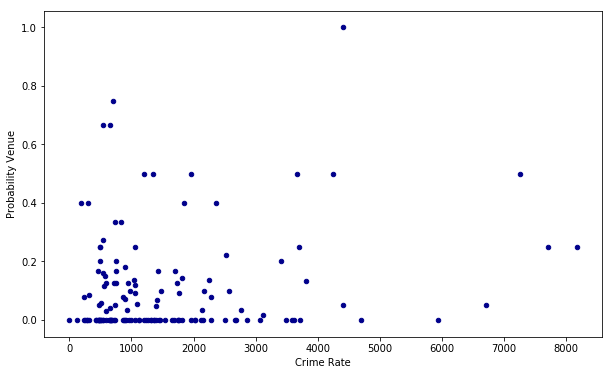

In [101]:
crimeToVenue =neighborhoods2[["Crime Rate", "Probability Venue"]]

crimeToVenue.plot(kind='scatter', x='Crime Rate', y='Probability Venue', figsize=(10, 6), color='darkblue')

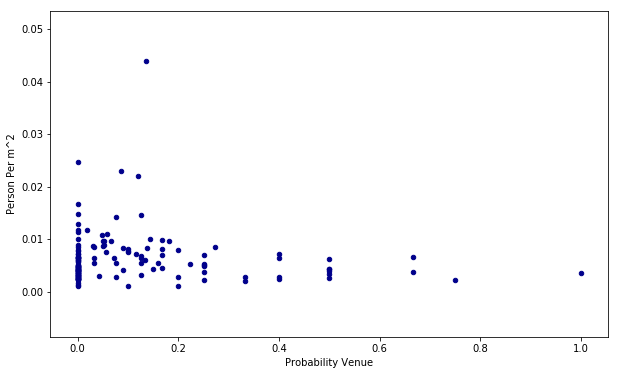

In [102]:
venueToPop =neighborhoods2[["Probability Venue", "Person Per m^2"]]

venueToPop.plot(kind='scatter', x='Probability Venue', y='Person Per m^2', figsize=(10, 6), color='darkblue')

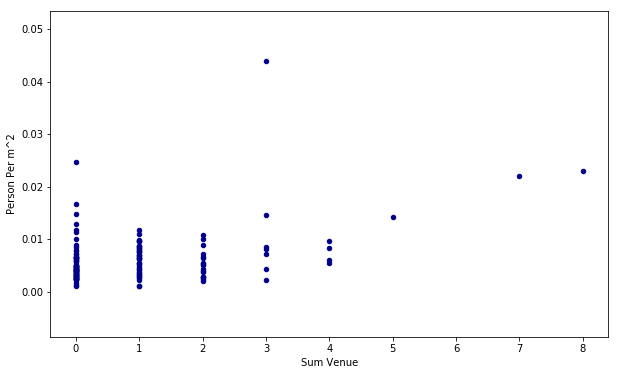

In [103]:
venueToPop =neighborhoods2[["Sum Venue", "Person Per m^2"]]

venueToPop.plot(kind='scatter', x='Sum Venue', y='Person Per m^2', figsize=(10, 6), color='darkblue')

In [104]:
num_top_venues = 10

for hood in area_grouped['AREA_SHORT_CODE']:
    print("----"+str(hood)+"----")
    temp = area_grouped[area_grouped['AREA_SHORT_CODE'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
   
    

KeyError: 'AREA_SHORT_CODE'

In [ ]:
crimeToPop =neighborhoods2[["Crime Rate", "Area m^2"]]

# crimeToPop.plot(kind='scatter', x='Crime Rate', y='Area m^2', figsize=(10, 6), color='darkblue')


In [ ]:
crimeToPop =neighborhoods2[["Crime Rate", "Population"]]

#crimeToPop.plot(kind='scatter', x='Crime Rate', y='Population', figsize=(10, 6), color='red')


In [ ]:
crimeToPop =neighborhoods2[["Population", "Area m^2"]]

crimeToPop.plot(kind='scatter', x='Population', y='Area m^2', figsize=(10, 6), color='green')

In [105]:

latitude = 43.70460773398059
longitude = -79.39715291165048

map_toronto= folium.Map(location=[latitude, longitude], zoom_start=10)
colorMap =["red","green","blue", "orange", "magenta"]

for lat, lng, neighborhood,klabel in zip(neighborhoods2['LATITUDE'], neighborhoods2['LONGITUDE'], neighborhoods2['AREA_NAME'],neighborhoods2['Labels']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    color=colorMap[klabel]
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto) 
map_toronto




In [ ]:
torontoNeighBoundries = f"https://raw.githubusercontent.com/DirkFritz/Coursera_Capstone/master/Neighbourhoods.geojson"

In [ ]:
folium.Choropleth(
    geo_data=gj,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2   
    ).add_to(map_toronto)
map_toronto.save(outfile= "test.html")

In [ ]:

for lat, lng, name, category in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name'], nearby_venues['categories']):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
 
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto